# News Sentiment Analysis – Natural Language Processing mit Transformern Baseline Modelle: Apple

## Vorbereitung

In [1]:
#Laden der benötigten Bibliotheken
import pandas as pd
import numpy as np
import nltk   #Natural Language ToolKit
from nltk.sentiment.vader import SentimentIntensityAnalyzer

In [2]:
#Daten einlesen
data = pd.read_csv("Apple.csv")

In [4]:
#Ersten Überblick über die Daten verschaffen
data.head()

,created_at,id,username,name,user_id,body,basic_sentiment
0,2021-12-31 23:57:27+00:00,422497650,hoyasaxa1978,hoyasaxa1978,819540,"$AAPL 🍏 In the “final second” of the Close, 8...",0.0
1,2021-12-31 23:51:08+00:00,422496711,InsiderFinance,InsiderFinance_io,4012623,Sweep Options Activity: $AAPL is the #1 ticker...,NaN
2,2021-12-31 23:48:33+00:00,422496310,OptionsQueenTrader,Malika,5498543,$SPY next year we will go low real low. Expect...,1.0
3,2021-12-31 23:47:55+00:00,422496202,BigdaddyRoy,Big Daddy,3830233,$AAPL someone told me Apple will announce Appl...,NaN
4,2021-12-31 23:44:31+00:00,422495691,hoangkc,Khanh Hoang,1553292,"The weekly #rrgchart of $AAPL, $AMZN, and $GOOGL",NaN


In [3]:
data["basic_sentiment"].value_counts()

0.0    17587
1.0     7439
Name: basic_sentiment, dtype: int64

Verteilung positive/negative Tweets deutlich unbalanciert.

## Pre-Processing

In [6]:
#html tags und urls entfernen
from bs4 import BeautifulSoup
data["tweets_preproc"]=data["body"].apply(lambda x: BeautifulSoup(x).get_text())
import re
data["tweets_preproc"]=data["tweets_preproc"].apply(lambda x: re.sub(r"http\S+", "", x))

In [8]:
#Sonderzeichen etc. entfernen
#Ressourcen downloaden
nltk.download('punkt')
data["tweets_preproc"]=data["tweets_preproc"].apply(lambda x: " ".join([re.sub('[^A-Za-z]+','', x) for x in nltk.word_tokenize(x)]))

In [9]:
#Überschüssige Leerzeichen entfernen
data["tweets_preproc"]=data["tweets_preproc"].apply(lambda x: re.sub(' +', ' ', x))

Weitere pre-processing Schritte (Lemmatization, Entfernen von Stopwords,...) wurden getestet, lieferten aber keine deutlichen Verbesserungen in der Modellgüte.

In [12]:
#Datumsvariable erstellen - um spaeter Ergebnisse zu plotten
data["created_at"] = pd.to_datetime(data.created_at, format='%Y-%m-%d %H:%M:%S')
data['date'] = data['created_at'].dt.strftime('%m/%d/%Y')

In [13]:
#Prüfen, ob alles geklappt hat
data.head()

,created_at,id,username,name,user_id,body,basic_sentiment,tweets_preproc,date
0,2021-12-31 23:57:27+00:00,422497650,hoyasaxa1978,hoyasaxa1978,819540,"$AAPL 🍏 In the “final second” of the Close, 8...",0.0,AAPL In the final second of the Close Million...,12/31/2021
1,2021-12-31 23:51:08+00:00,422496711,InsiderFinance,InsiderFinance_io,4012623,Sweep Options Activity: $AAPL is the #1 ticker...,NaN,Sweep Options Activity AAPL is the ticker with...,12/31/2021
2,2021-12-31 23:48:33+00:00,422496310,OptionsQueenTrader,Malika,5498543,$SPY next year we will go low real low. Expect...,1.0,SPY next year we will go low real low Expect ...,12/31/2021
3,2021-12-31 23:47:55+00:00,422496202,BigdaddyRoy,Big Daddy,3830233,$AAPL someone told me Apple will announce Appl...,NaN,AAPL someone told me Apple will announce Appl...,12/31/2021
4,2021-12-31 23:44:31+00:00,422495691,hoangkc,Khanh Hoang,1553292,"The weekly #rrgchart of $AAPL, $AMZN, and $GOOGL",NaN,The weekly rrgchart of AAPL AMZN and GOOGL,12/31/2021


In [14]:
#Datensatz nur mit gelabelten Tweets
data_labeled = data.dropna(subset = ["basic_sentiment"])
data_labeled = data_labeled.reset_index(drop=True)

## Sentiment Analysis

### 1 - VADER

In [16]:
#nltk.download('vader_lexicon')
sid = SentimentIntensityAnalyzer()
#model
data_labeled["v_scores"] = data_labeled["tweets_preproc"].apply(lambda body: sid.polarity_scores(body))

In [17]:
#eigene Spalte für scores erstellen
data_labeled['compound']  = data_labeled['v_scores'].apply(lambda score_dict: score_dict['compound'])

In [18]:
#Predictions
data_labeled['v_sentiment'] = (
    np.where(
        data_labeled['compound'] > 0.05,1,
        np.where(data_labeled['compound'] < -0.05, 0, -99)))

Modellauswertung mittels Gütemaßen oder Confusion Matrix ist für VADER nicht sinnvoll, da VADER drei Klassen (positiv/neutral/negativ) hat, die Tweets im Datensatz aber nur zwei Klassen (positiv/negativ). Eine grafische Betrachtung folgt weiter unten.

### 2 - TF - IDF

In [21]:
#train / test split mit gleichen Anteilen der Klassen in Trainings- und Testdaten
from sklearn.model_selection import train_test_split
baseline_train,baseline_test = train_test_split(data_labeled,
                                                  stratify = data_labeled["basic_sentiment"],
                                                  test_size=0.1, random_state=42)
print("Training Set: ",baseline_train.shape, "Test Set: ",baseline_test.shape)

Training Set:  (22523, 12) Test Set:  (2503, 12)


In [23]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(ngram_range=(1, 2), norm="l2")
vectorizer.fit(baseline_train["tweets_preproc"])
tf_x_train = vectorizer.transform(baseline_train["tweets_preproc"])
tf_x_test = vectorizer.transform(baseline_test["tweets_preproc"])

In [27]:
#SVM classifier
from sklearn import svm
svm = svm.SVC(class_weight={1:96.3, 0:3.7})

In [32]:
#Grid Search
from sklearn.model_selection import GridSearchCV
param_grid = [
  {'C': np.logspace(-3, 2, 6), 'kernel': ['linear']},
  {'C': np.logspace(-3, 2, 6), 'gamma': np.logspace(-3, 2, 6), 'kernel': ['rbf']},
 ]

grid_search = GridSearchCV(svm, param_grid, n_jobs = -1, verbose = 2)
grid_search.fit(tf_x_train, baseline_train["basic_sentiment"])

Fitting 5 folds for each of 42 candidates, totalling 210 fits


GridSearchCV(estimator=SVC(class_weight={0: 3.7, 1: 96.3}), n_jobs=-1,
             param_grid=[{'C': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02]),
                          'kernel': ['linear']},
                         {'C': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02]),
                          'gamma': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02]),
                          'kernel': ['rbf']}],
             verbose=2)

In [33]:
print(grid_search.best_params_)

{'C': 10.0, 'gamma': 1.0, 'kernel': 'rbf'}


In [34]:
#Bestes Modell auf Testdaten anwenden und fitted values speichern
model_svm = grid_search.best_estimator_
y_fit_svm = model_svm.predict(tf_x_test)
baseline_test["sentiment_svm"] = y_fit_svm

In [35]:
#ergebnisse /modellgüte
svm_results=classification_report(baseline_test["basic_sentiment"], y_fit_svm,output_dict=True)

In [36]:
#Confusion matrix
cm_svm = confusion_matrix(baseline_test["basic_sentiment"], y_fit_svm_base)

In [38]:
svm_results

{'0.0': {'precision': 0.8380952380952381,
  'recall': 0.8504832291074474,
  'f1-score': 0.8442437923250565,
  'support': 1759},
 '1.0': {'precision': 0.6337047353760445,
  'recall': 0.6115591397849462,
  'f1-score': 0.6224350205198358,
  'support': 744},
 'accuracy': 0.7794646424290851,
 'macro avg': {'precision': 0.7358999867356413,
  'recall': 0.7310211844461969,
  'f1-score': 0.7333394064224461,
  'support': 2503},
 'weighted avg': {'precision': 0.777341528936996,
  'recall': 0.7794646424290851,
  'f1-score': 0.7783126192435207,
  'support': 2503}}

[Text(0, 0.5, 'positive'), Text(0, 1.5, 'negative')]

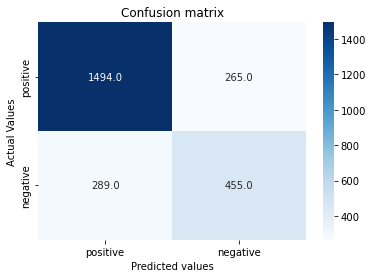

In [86]:
ax = sns.heatmap(cm_svm, annot=True, cmap = 'Blues',fmt = '.1f')
ax.set_title('Confusion matrix')
ax.set_xlabel('Predicted values')
ax.set_ylabel('Actual Values')
ax.xaxis.set_ticklabels(['positive','negative'])
ax.yaxis.set_ticklabels(['positive','negative'])

Probleme beim Erkennen negativer Tweets erkennbar.

## Ergebnisse plotten

In [62]:
baseline_test["basic_sentiment"] = (np.where((baseline_test["basic_sentiment"] == 0) ,0,1))

In [63]:
baseline_test["sentiment_svm"] = (np.where((baseline_test["sentiment_svm_base"] == 0),0,1))

In [64]:
#Funktion, die Dummyvariablen erstellt und zum Dataframe hinzufügt
def dummies(dataframe, columns):
    dummy_df = pd.get_dummies(data = dataframe, columns = columns, dtype = np.float64)
    return dummy_df

In [65]:
dummy_vars = ['basic_sentiment','sentiment_svm','v_sentiment']
baseline_test = dummies(baseline_test, dummy_vars)

In [66]:
#Aggregieren auf Tagesebene
sentiment_scores_test = baseline_test.groupby("date").agg({'basic_sentiment_1': sum,
                                                           'basic_sentiment_0': sum,
                                                           'sentiment_svm_1': sum,
                                                           'sentiment_svm_0':sum,
                                                          'v_sentiment_0':sum,
                                                          'v_sentiment_1':sum,
                                                          'v_sentiment_-99':sum})                                          
                                                           

In [67]:
#Sentiment Score berechnen
def sentiment_score(pos,neg):
    avg_score = (pos - neg) / (pos + neg)
    return avg_score

In [68]:
#Wie oben, nur für drei Klassen
def sentiment_vader(pos,neg,neutr):
    avg_score = (pos - neg) / (pos + neg + neutr)
    return avg_score

In [69]:
sentiment_scores_test["basic"] = sentiment_score(sentiment_scores_test["basic_sentiment_0"], sentiment_scores_test["basic_sentiment_1"])
sentiment_scores_test["predicted"] = sentiment_score(sentiment_scores_test["sentiment_svm_0"], sentiment_scores_test["sentiment_svm_1"])
sentiment_scores_test["vader"] = sentiment_vader(sentiment_scores_test["v_sentiment_1"], sentiment_scores_test["v_sentiment_0"], sentiment_scores_test["v_sentiment_-99"])

In [70]:
#Datumsvariable aus Indexvariable erstellen
sentiment_scores_test["date"] = sentiment_scores_test.index

In [71]:
sentiment_scores_test["date"] = pd.to_datetime(sentiment_scores_test.date, format='%m/%d/%Y')

In [76]:
#Plotten
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
import matplotlib.ticker as ticker
%matplotlib inline

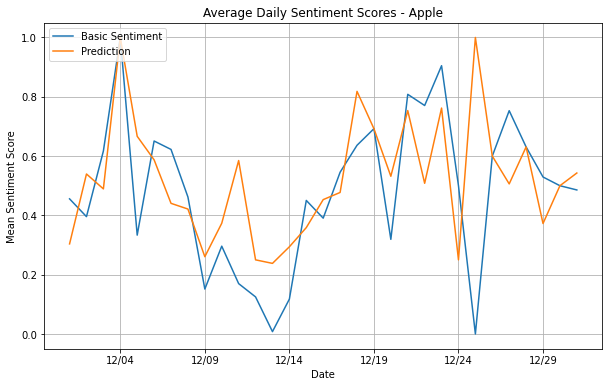

In [83]:
#Plot TF-IDF
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(sentiment_scores_test["date"],sentiment_scores_test.basic, label = 'Basic Sentiment')
ax.plot(sentiment_scores_test["date"], sentiment_scores_test["predicted"], label = 'Prediction')
ax.set_xlabel('Date')
ax.set_ylabel('Mean Sentiment Score')
ax.set_title('Average Daily Sentiment Scores - Apple')
ax.grid(True)
ax.legend(loc='upper left');

#format date axis
date_form = DateFormatter("%m/%d")
ax.xaxis.set_major_formatter(date_form)
#change interval 
ax.xaxis.set_major_locator(ticker.AutoLocator())

Verlauf von Predictions und tatsächlichem Sentiment ähnlich. Predictions leicht positiver, da negative Tweets vom Modell nicht gut erkannt. Auffällig ist der stark abweichende Verlauf am 25.12. Grund hierfür könnte sein, dass für diesen Tag nur vier Tweets existieren

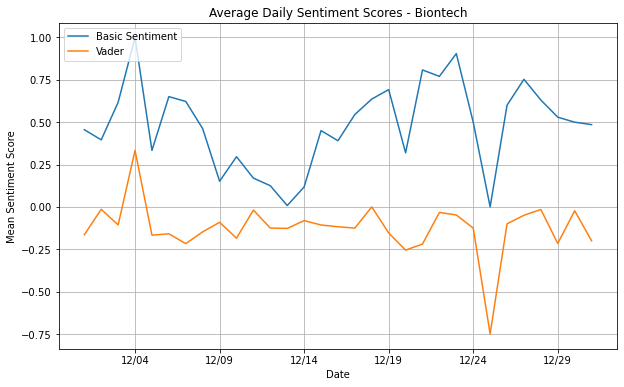

In [78]:
#Zum Vergleich VADER
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(sentiment_scores_test["date"],sentiment_scores_test.basic, label = 'Basic Sentiment')
ax.plot(sentiment_scores_test["date"], sentiment_scores_test["vader"], label = 'Vader')
ax.set_xlabel('Date')
ax.set_ylabel('Mean Sentiment Score')
ax.set_title('Average Daily Sentiment Scores - Apple')
ax.grid(True)
ax.legend(loc='upper left');

#format date axis
date_form = DateFormatter("%m/%d")
ax.xaxis.set_major_formatter(date_form)
#change interval 
ax.xaxis.set_major_locator(ticker.AutoLocator())

Auch mit VADER lässt sich der Verlauf des Sentiments recht gut vorhersagen. Die deutlichen Unterschiede im Mean Sentiment Score werden dadurch verursacht, dass VADER einen Großteil der Tweets als neutral klassifiziert und somit einer Klasse zuordnet, die in den gelabelten Daten nicht existiert. 